# Let's Build an Agent from Scratch!



---


**VERSION HISTORY - DON'T DELETE**

* V5.0 - March 9, 2025 - Removed Wikipedia tool; Fixed date bug and search tool reference in system prompt - Rama Ramakrishnan
* V4.0 - March 9, 2025 - Added Google Search tool; use GPT 4o so updated prompts - Vivek Farias
* V3.0 - March 9, 2025 - Replaced OOP code completely with functional code, added more explanatory notes - Rama Ramakrishnan
* V2.0 - March 7, 2025 - "Robustified" the system prompt, added examples - Rama Ramakrishnan
* V1.0 - March 6, 2025 - Initial attempt - Rama Ramakrishnan

(if you see errors, please email ramar@mit.edu or vivekf@mit.edu)


*Note to HODL teaching team*: To make edits or run the colab, please do it on a copy (File > Save a copy in Drive).

---



**CREDIT**: Substantially modified and extended version of https://til.simonwillison.net/llms/python-react-pattern

## Introduction
There are lots of software frameworks for building agents. But since they obscure a lot of the details, they are not ideal for **really** understanding what's going on.

To learn the key ideas, there's nothing better than building one yourself from scratch. In this colab, we will use just basic Python code to give `GPT-4o-mini` agentic superpowers 🚀!



---

Here is the overall plan for transforming `GPT-4o-mini` into an Agent.

1. We will create three **tools**. As we saw in lecture, you can think of a tool as just a **function**. So, we will define three Python functions to do the following:
  * calculate something
  * search Google
  * fetch a weather forecast

2. We will design a prompt that "teaches" `GPT-4o-mini` how and when to use these functions. To do so, we will use a simplified version of a popular Agentic framework called ReAct ([academic paper](https://arxiv.org/abs/2210.03629)).

3. We will write some basic code to assemble the prompt and the functions into an `ask_the_agent` function (similar to the `ask_the_LLM` function from the ["How to use the LLM API" colab](https://colab.research.google.com/drive/1BUSmrCy8r11HJk-7H3BYM5kmvmMp92a-?usp=sharing))



---



## Setup

In [ ]:
from google.colab import userdata

from openai import OpenAI
client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

## Function Definitions

### A calculator funcion

To evaluate any arithmetic expression written in Python syntax, the `eval` function is very handy. For example:

In [ ]:
eval('23 * 45')

1035

We will define a little function called `calculate` that uses `eval`.

In [ ]:
def calculate(expression):
    return eval(expression)

### A function to get the high-temperature forecast for a location using the (free) Openmeteo API


We will use the `openmeteo-requests` Python package for this, so let's install it first.

In [ ]:
!pip install openmeteo-requests

In [ ]:
import openmeteo_requests
def get_weather(input):
    openmeteo = openmeteo_requests.Client()

    url = "https://api.open-meteo.com/v1/forecast"

    lat, long = [float(e.strip()) for e in input.split(",")]

    params = {
      "latitude": lat,
      "longitude": long,
      "daily": "temperature_2m_max",
      "temperature_unit": "fahrenheit"
    }
    responses = openmeteo.weather_api(url, params=params)

    daily = responses[0].Daily()
    daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()

    return f"Today's high temperature: {daily_temperature_2m_max[0]}"

## And finally, a function to search Google

In [ ]:
import requests

def google_search(query, num_results=3):
    """Fetches the top results from Google Custom Search API with longer snippets."""
    url = "https://www.googleapis.com/customsearch/v1"
    params = {
        "key": userdata.get('GOOGLE_API_KEY'),
        "cx": userdata.get('GOOGLE_CSE_ID'),
        "q": query,
        "num": num_results,
        "fields": "items(title,snippet,link)"
    }
    response = requests.get(url, params=params)
    response.raise_for_status()
    results = response.json().get("items", [])

    return "\n".join([item.get("snippet", "N/A") for item in results])

Now that we have these three functions defined, we will collect them into a dictionary to make it easy to run them later without ugly if-elif-else statements.

In [ ]:
available_functions = {
    "calculate": calculate,
    "get_weather": get_weather,
    "google_search": google_search
}

## The System Prompt

It is useful for our agent to know today's date at our current location, so we can use the `datetime` and `pytz` packages to figure that out.

In [ ]:
from datetime import datetime
import pytz

# Define the Cambridge, MA timezone (Eastern Time Zone)
cambridge_tz = pytz.timezone("America/New_York")

# Get the current date in the specified timezone
today_date = datetime.now(cambridge_tz).strftime("%B %d, %Y")

today_date

'March 10, 2025'

OK, let's go through the system prompt slowly.

In [ ]:
system_prompt = f"""
Today's date is {today_date}. Your training cutoff date is October 2023.

If you are asked about events that you know FOR SURE happened before
your cutoff date, answer the question directly.

If you are asked the following types of questions:
- about events that MAY have happened after your cutoff date,
- arithmetic questions that a human cannot easily do in their head
- about the weather at a location,
do the following:

Run in a loop of Thought, Action, PAUSE, Observation.
You can run this loop as many times as you want.
At the end of the final loop you output an Answer.

Use Thought to describe your thoughts about the question you have been asked.
Use Action to execute one of the functions described below - then return PAUSE.
Observation will be the result of running those functions.

Your available functions are:

calculate:
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary
e.g. calculate: 4 * 7 / 3

google_search:
This returns a search result from searching Google including the title of the page, a snippet of its content, and the page url.
e.g., google_search: Who won the Nets Hornets game?

get_weather:
If asked about the weather for a location, first determine the latitude and longitude of the location.
Then call get_weather: latitude, longitude
e.g., get_weather: 37.7749,-122.4194


Example session 1:

Question: What is the capital of France?
Thought: I know the answer to this question. The capital of France is Paris.
I don't need to use any of the available tools to answer this question.
Answer: The capital of France is Paris.

Example session 2:
Question: What is the square root of 36373.33?
Thought: I need to use the calculate function to answer this question.
Action: calculate: 36373.33**(1/2)
PAUSE

You will be called again with this:

Observation: 190.717

You then output:
Answer: The square root of 36373.33 is 190.717

Example session 3:
Question: In which year was ChatGPT first released?
Thought: This did not happen before my cutoff date. I need to use the google_search function to answer this question.
Action: search_google: chatgpt release date
PAUSE

You will be called again with this:

Observation: Web browsing and Plugins are now rolling out in beta (May 12, 2023). If you are a ChatGPT Plus user, enjoy early access to experimental new features, which may ...
May 19, 2023 ... OpenAI released an early demo of ChatGPT on November 30, 2022, and the chatbot quickly went viral on social media as users shared examples of ...
ChatGPT was publicly released on November 30, 2022. At the time of its release, it was described as a “research preview,” but it is still available now.

You then output:
Answer: ChatGPT was released in 2022

Example session 4:
Question: How good is the MacBook M4 Pro?
Thought: I don't know what this product is. I need to use the google_search function to answer this question.
Action: search_google: macbook m4 pro reviews
PAUSE

You will be called again with this:

Observation: Nov 17, 2024 ... The M4 MacBook Pro raises the performance bar compared to the M3 series in several ways: Much easier to see clearly when working near windows or outside.
Dec 16, 2024 ... This machine is a beast. My day to day use involves writing and presentations, chrome tabs, AI tools, SPSS data processing and light video editing.
Nov 12, 2024 ... The good · RAM upgrades across the whole lineup. · M4 and M4 Max are both respectable generational upgrades and offer substantial performance ...

You then output:
Answer: The M4 MacBook Pro offers clear performance gains over the M3 lineup, with improvements in display visibility, multitasking capabilities, and RAM options. While praised for its power, some reviews suggest that the fastest model may not feel like a game-changer in everyday tasks.

""".strip()

In [ ]:
print(system_prompt)

Today's date is March 10, 2025. Your training cutoff date is October 2023.

If you are asked about events that you know FOR SURE happened before
your cutoff date, answer the question directly.

If you are asked the following types of questions:
- about events that MAY have happened after your cutoff date,
- arithmetic questions that a human cannot easily do in their head
- about the weather at a location,
do the following:

Run in a loop of Thought, Action, PAUSE, Observation.
You can run this loop as many times as you want.
At the end of the final loop you output an Answer.

Use Thought to describe your thoughts about the question you have been asked.
Use Action to execute one of the functions described below - then return PAUSE.
Observation will be the result of running those functions.

Your available functions are:

calculate:
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary
e.g. calculate: 4 * 7 / 3

google_search:
This r

## The "Orchestration" Loop

We now write a function to "orchestrate" the flow (see slide below from lecture ).

We will call the LLM (i.e., GPT-4.0-Mini), run a function, call the LLM again with the results and so on, till we figure out the answer.

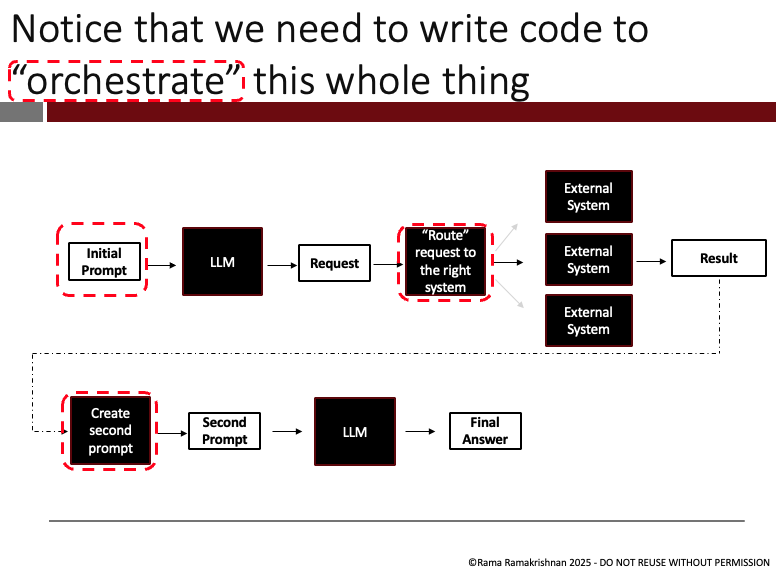

In [ ]:
# a bit later on, we will need to parse the LLM response to see if the word 'Action'
# appears at the start of the response. We will use a regular expression for
# this. If you aren't familiar with this, please copy-paste the two lines
# below into an LLM and ask for an explanation.
import re
action_re = re.compile('^Action: (\w+): (.*)$')


# This function will call the LLM, run a function, call the LLM again
# with the results and so on, till we either figure out the answer or
# run out of "turns"

def ask_the_agent(question, max_turns=5):
    i = 0

    # this list will contain the entire conversation
    # between the user and the LLM
    messages = []

    # we will first put in the long prompt from above
    # as the "system prompt" so that it is part of every
    # question
    messages.append({"role": "system", "content": system_prompt})


    # we start with the opening question from the user
    next_prompt = question

    while i < max_turns:  # we allow the conversation to have 5 turns
        i += 1

        # we send the conversation-so-far to the LLM and get the response
        messages.append({"role": "user", "content": next_prompt})
        completion = client.chat.completions.create(model="gpt-4o-mini",
                                            messages=messages,
                                            temperature=0)
        result = completion.choices[0].message.content
        messages.append({"role": "assistant", "content": result})
        print(result)


        # we parse the response to see if the word 'Action' appears at the start
        # of the response
        actions = [action_re.match(a) for a in result.split('\n') if action_re.match(a)]

        if actions: # if it does ...

            # we identify which function to call and its inputs
            action, action_input = actions[0].groups()

            # if the LLM responds with an action that is not on our
            # list of available functions, we say "sorry"
            if action not in available_functions:
                raise Exception("Unknown function: {}: {}".format(action, action_input))

            # otherwise, we print out what function we are going to run ...
            print(" -- running {} {}".format(action, action_input))

            # ... and then actually run it
            observation = available_functions[action](action_input)

            # we print out the result of running the function ...
            print("Observation:", observation)

            # ... and make that the next prompt
            next_prompt = "Observation: {}".format(observation)
        else:
            return



OK, now are all set to test the Agent out.

To clearly demonstrate agentic behavior, we will first pose a question to 'GPT-4o-mini' using the `ask_the_LLM` function below (copy-pasted from the ["How to use the LLM API" colab](https://colab.research.google.com/drive/1BUSmrCy8r11HJk-7H3BYM5kmvmMp92a-?usp=sharing)). We will then pose the same question to the Agent. Pay attention to how the responses differ.

In [ ]:
# copy-pasted from "How to use the LLM API" colab

def ask_the_LLM(prompt,
                model="gpt-4o-mini",
                temperature=0):

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "system",
                   "content": "You are a helpful assistant."},
                  {"role": "user", "content": prompt}],
        temperature=temperature
    )
    return response.choices[0].message.content

## Examples

### Example of the agent NOT using tools if it doesn't have to

In [ ]:
ask_the_LLM("When was Maggie Smith born?")

'Maggie Smith was born on December 28, 1934.'

In [ ]:
ask_the_agent("When was Maggie Smith born?")

Thought: I know that Maggie Smith is a well-known actress, and I can provide her birth date without needing to use any tools. 
Answer: Maggie Smith was born on December 28, 1934.


### Example of the agent using web search: Ask about something that happened after GPT-4o-mini's training cutoff date

In [ ]:
ask_the_LLM("In which year did Maggie Smith breathe her last?")

'As of my last knowledge update in October 2023, Maggie Smith is still alive. Please verify with the latest sources for the most current information.'

In [ ]:
ask_the_agent("In which year did Maggie Smith breathe her last?")

Thought: I know that Maggie Smith is a well-known actress, but I need to verify if she has passed away since my training cutoff date. I will use the google_search function to find the most current information about her status. 
Action: google_search: Maggie Smith death date
PAUSE
 -- running google_search Maggie Smith death date
Observation: Dame Margaret Natalie Smith (28 December 1934 – 27 September 2024) was a British actress. Known for her wit in both comedic and dramatic roles, ...
Sep 28, 2024 ... In 2022's Downton Abbey: A New Era, her character died of the illness she revealed at the end of the 2019 film. Co-star Dame Harriet Walter told ...
Sep 30, 2024 ... It did not specify the cause of death. American moviegoers barely knew Ms. Smith (now Dame Maggie to her countrymen) when she starred in “The ...
Answer: Maggie Smith passed away on September 27, 2024.


### Example of the agent using the calculator: Ask a numeric calculation question that LLMs have difficulty with

In [ ]:
ask_the_LLM("What is the cube root of 473740284833?")

'To find the cube root of \\( 473740284833 \\), we can use a calculator or perform the calculation manually.\n\nCalculating the cube root:\n\n\\[\n\\sqrt[3]{473740284833} \\approx 778\n\\]\n\nTo verify, we can cube \\( 778 \\):\n\n\\[\n778^3 = 778 \\times 778 \\times 778 = 473740284833\n\\]\n\nThus, the cube root of \\( 473740284833 \\) is indeed \\( 778 \\).'

Is this correct? Let's check.

In [ ]:
473740284833**(1/3)

7795.550194955124

Oops, the LLM gets it wrong. OK, let's ask our Agent.

In [ ]:
ask_the_agent("What is the cube root of 473740284833?")

Thought: I need to use the calculate function to find the cube root of 473740284833.
Action: calculate: 473740284833**(1/3)
PAUSE
 -- running calculate 473740284833**(1/3)
Observation: 7795.550194955124
Answer: The cube root of 473740284833 is approximately 7795.55.


Beautiful!!

### Example of the agent using its knowledge **and** a tool in combination to answer a complex question

In [ ]:
ask_the_LLM("What is the capital of Vermont and what is the weather there?")

'The capital of Vermont is Montpelier. As for the weather, it can vary significantly depending on the time of year. In general, Montpelier experiences cold winters with snowfall and warm summers. For the most current weather conditions, I recommend checking a reliable weather website or app, as I cannot provide real-time weather updates.'

In [ ]:
ask_the_agent("What is the capital of Vermont and what is the weather there?")

Thought: I know the capital of Vermont is Montpelier. However, I need to find out the current weather there, which requires using the get_weather function. 
Action: get_weather: 44.2601,-72.5714
PAUSE
 -- running get_weather 44.2601,-72.5714
Observation: Today's high temperature: 41.87839889526367
Answer: The capital of Vermont is Montpelier, and today's high temperature there is approximately 41.88°F.


Now how the agent first used its "knowledge" to get the latitude and longitude of Montpelier and then used the `get_weather` function. Impressive!

### Example of the agent using **multiple tools** to answer a complex question




In [ ]:
ask_the_LLM("In which year did Maggie Smith breathe her last \
and what is the cube root of that number?")

'As of my last knowledge update in October 2023, Maggie Smith is still alive. Therefore, there is no year in which she has breathed her last. If you have any other questions or need information on a different topic, feel free to ask!'

In [ ]:
ask_the_agent("In which year did Maggie Smith breathe her last and what is the cube root of that number?")

Thought: I need to find out when Maggie Smith passed away, as this information is not known to me. After that, I will calculate the cube root of that year. I will use the google_search function to find the year of her passing. 
Action: google_search: Maggie Smith death date
PAUSE
 -- running google_search Maggie Smith death date
Observation: Dame Margaret Natalie Smith (28 December 1934 – 27 September 2024) was a British actress. Known for her wit in both comedic and dramatic roles, ...
Sep 28, 2024 ... In 2022's Downton Abbey: A New Era, her character died of the illness she revealed at the end of the 2019 film. Co-star Dame Harriet Walter told ...
Sep 30, 2024 ... It did not specify the cause of death. American moviegoers barely knew Ms. Smith (now Dame Maggie to her countrymen) when she starred in “The ...
Thought: Maggie Smith passed away on September 27, 2024. Now, I need to calculate the cube root of the year 2024. 
Action: calculate: 2024**(1/3)
PAUSE
 -- running calculate 2024*

In [ ]:
ask_the_agent("In which year did the actress for Minerva McGonagall in \
Harry Potter breathe her last? And what is the cube root of that number?")

Thought: I need to find out when the actress who played Minerva McGonagall in Harry Potter passed away. After that, I will calculate the cube root of that year. I will use the google_search function to find the actress's death year. 

Action: google_search: Minerva McGonagall actress death year
PAUSE
 -- running google_search Minerva McGonagall actress death year
Observation: She portrayed Professor Minerva McGonagall in the Harry Potter film series (2001–2011). She also acted in Death on the Nile (1978), Hook (1991), Sister Act ...
Jul 10, 2021 ... I asked my fiancé, “hey is McGonagall's actress still alive?” “I'm pretty sure she died.” “How long ago?” “Ehh, it was fairly recently… a couple ...
Sep 27, 2024 ... Actor Michael Gambon Smith, who played Professor McGonagall in the fantasy franchise, died at age 89 on Friday, Sept. 27, while Gambon died on the same date in ...
Thought: The search results did not provide the name of the actress who played Minerva McGonagall, but they mentio

In [ ]:
ask_the_agent("I made a bet on the most recent Lakers Celtics game. \
I win the square of the point difference if the Celtics won. Do I win or lose? How much?")

Thought: I need to find out the result of the most recent Lakers vs. Celtics game to determine if the Celtics won and what the point difference was. I will use the google_search function to find this information.

Action: google_search: Lakers Celtics most recent game result March 2025
PAUSE
 -- running google_search Lakers Celtics most recent game result March 2025
Observation: 1 day ago ... The Celtics defeated the Lakers, 111-101 tonight in Boston. Jayson Tatum contributed a team-high 40 points to go with 12 rebounds 8 assists ...
2 days ago ... Los Angeles Lakers vs Boston Celtics Mar 8, 2025 game result ... The Lakers stretched their winning streak to eight games by beating the New ...
1 day ago ... ... as of March 10, 2025 | GAME RESULTS | NBA SCHEDULE March 11, 2025. EXTRA14 Update Channel New 38K views · 12:34 · Go to channel · Stephen A.
Thought: The Celtics won the game against the Lakers with a score of 111-101. Now, I need to calculate the point difference and then find the

In [ ]:
ask_the_agent("I made a bet on the March 2 Celtics game. \
I win the square of the point difference if the Celtics won. Do I win or lose? How much?")

Thought: I need to find out the result of the March 2 Celtics game to determine if the Celtics won and what the point difference was. I will use the google_search function to find this information.

Action: google_search: Celtics game result March 2 2025
PAUSE
 -- running google_search Celtics game result March 2 2025
Observation: BOSTON (AP) Jaylen Brown scored 22 points and Derek White hit a floater from the foul line with less than a minute left on Sunday to help the Boston Celtics ...
Game summary of the Boston Celtics vs. Denver Nuggets NBA game, final score 110-103, from March 2, 2025 on ESPN.
Celtics bounce back. TD Garden, Boston, MA. Watch on the NBA AppGame Recap.
Thought: The Celtics won the game against the Denver Nuggets with a final score of 110-103. Now, I need to calculate the point difference, which is 110 - 103 = 7. I will then calculate the square of the point difference to determine how much I win.

Action: calculate: 7**2
PAUSE
 -- running calculate 7**2
Observatio

Our little agent called several functions in sequence and answered the question correctly!!! 🚀


WOW. RESPECT.

## Conclusion

By just defining three functions using basic Python and setting up a prompt carefully, we were able to elicit 'agentic' behavior from GPT-4o-mini!!

That said, it is quite easy to ask questions that stump this agent. For a more robust implementation, we would need to use more powerful LLMs (ideally, reasoning LLMs like OpenAI o3) and have more validation checks, fallbacks etc.